# Masking data-cubes using geometry objects

In [1]:
# If first time running, uncomment the line below to install any additional dependencies
# !bash requirements-for-notebooks.sh

In [2]:
import matplotlib.pyplot as plt

from earthkit.transforms import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file

## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray` or `geopandas` objects.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

First we lazily load the ERA5 data  and NUTS geometries from our test-data repository.

Note the data is only downloaded when
we use it, e.g. at the `.to_xarray` line, additionally, the download is cached so the next time you run this
cell you will not need to re-download the file (unless it has been a very long time since you have run the
code, please see tutorials in `earthkit-data` for more details in cache management).

In [3]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
# remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib") # Large file
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_20150101.grib")
era5_data = ek_data.from_source("url", remote_era5_file)
era5_data.to_xarray()

<xarray.Dataset> Size: 5MB
Dimensions:     (number: 1, time: 24, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 192B ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T13:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ek_data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.4792 45.193, 21.3585 44.8216, 22...."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,..."


## Mask dataarray with geodataframe

`shapes.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object the same shape and type as the input xarray object with all points outside of
the geometry masked

In [5]:
single_masked_data = ek_aggregate.spatial.mask(era5_data, nuts_data)
single_masked_data

<xarray.Dataset> Size: 5MB
Dimensions:     (number: 1, time: 24, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 192B ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T13:59 GRIB to CDM+CF via cfgrib-0.9.1...

Text(0.5, 1.0, 'Masked data')

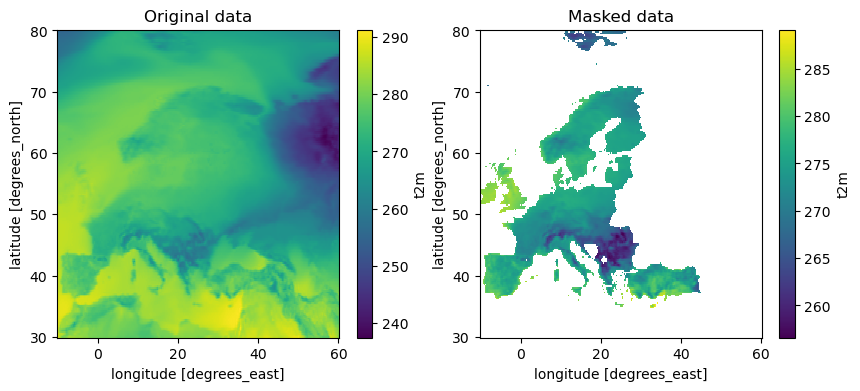

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
era5_data.to_xarray().t2m.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
# Single masked data
single_masked_data.t2m.mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked data')

`shapes.masks` applies the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object with an additional dimension, and coordinate variable, corresponding to the 
features in the geometry object.
By default this is the index of the input geodataframe, in this example the index is just an integer
count so it takes the default name `index`.

In [7]:
masked_data = ek_aggregate.spatial.masks(era5_data, nuts_data)
masked_data

<xarray.Dataset> Size: 201MB
Dimensions:     (index: 37, number: 1, time: 24, step: 1, surface: 1,
                 latitude: 201, longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 192B dask.array<chunksize=(24, 1), meta=np.ndarray>
  * index       (index) int64 296B 0 1 2 3 4 5 6 7 8 ... 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, number, time, step, surface, latitude, longitude) float32 201MB dask.array<chunksize=(1, 1, 24, 1, 1, 201, 281), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T13:59 GRIB to CDM+CF via cfgrib-0.9.1...

It is possible to specify a column in the geodataframe to use for the new dimension, for example in NUTS the
`FID` (= feature id) which contains the two letter identier code for each feature:

In [8]:
masked_data = ek_aggregate.spatial.masks(era5_data, nuts_data, mask_dim="FID")
masked_data

<xarray.Dataset> Size: 201MB
Dimensions:     (FID: 37, number: 1, time: 24, step: 1, surface: 1,
                 latitude: 201, longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 192B dask.array<chunksize=(24, 1), meta=np.ndarray>
  * FID         (FID) object 296B 'DK' 'RS' 'EE' 'EL' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m         (FID, number, time, step, surface, latitude, longitude) float32 201MB dask.array<chunksize=(1, 1, 24, 1, 1, 201, 281), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-15T13:59 GRIB to CDM+CF via cfgrib-0.9.1...

Here we demonstrate what we have done by plotting the masked objects we have produced

Text(0.5, 1.0, 'Masked Germany Zoom')

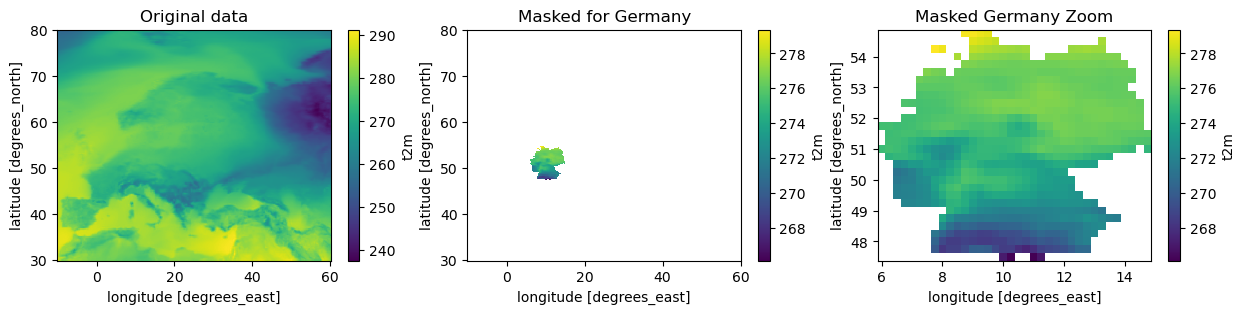

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
era5_data.to_xarray().t2m.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
masked_data.t2m.sel(FID='DE').mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked for Germany')
germany_data = masked_data.sel(FID='DE').dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
germany_data.t2m.mean(dim='time').plot(ax=axes[2])
axes[2].set_title('Masked Germany Zoom')